In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import fastai
from fastai.vision import *
import pandas as pd
import os
from shutil import copyfile


In [3]:
torch.cuda.set_device(0)
df_train = pd.read_csv('../train-rle.csv')
exp_label = 'exp10'
model_name = 'resnet34'
full_resolution = 512
half_resolution = 256
print(f"classifier_data_{full_resolution}/")

classifier_data_512/


In [4]:
np.random.seed(42)
src = (ImageList.from_folder(f"classifier_data_{full_resolution}/")
                .split_by_rand_pct(0.1)
                .label_from_folder())
# Starting with image size 256
tfms = get_transforms(do_flip=True, max_rotate=15, flip_vert=False, max_lighting=0.1,
                      max_warp=0.,
                      xtra_tfms=[rand_crop(), rand_zoom(0.75, 1.25),
                                 symmetric_warp(magnitude=(-0.2, 0.2))])
data = (src.transform(tfms, size=half_resolution)
           .databunch(bs=64, path='.').normalize(imagenet_stats))

In [5]:
from torch import nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()

In [6]:
precision = Precision()
recall    = Recall()
auroc     = AUROC()
f1_score  = FBeta(beta=1)
f2_score  = FBeta(beta=2)
learn = cnn_learner(data, models.resnet34, metrics=[accuracy,precision,recall,auroc,f1_score,f2_score], model_dir=".", callback_fns=ShowGraph)
learn.loss_fn = FocalLoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 3.98E-03


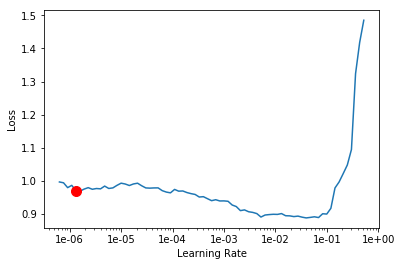

In [7]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,f_beta,f_beta,time
0,0.746006,0.575993,0.699935,0.722619,0.725209,0.770056,0.723912,0.724690,00:34
1,0.621059,0.546876,0.718730,0.729761,0.764636,0.793370,0.746791,0.757396,00:44
2,0.562702,0.510526,0.737524,0.752927,0.768220,0.825500,0.760497,0.765112,00:49
3,0.529108,0.499104,0.751782,0.794805,0.731183,0.834550,0.761668,0.743079,00:50
4,0.517671,0.489696,0.763448,0.793532,0.762246,0.841675,0.777575,0.768304,00:49
5,0.512887,0.488610,0.760855,0.781928,0.775388,0.842687,0.778644,0.776687,00:48


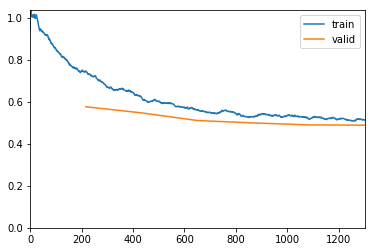

In [8]:
lr = 1e-3
learn.freeze()
learn.fit_one_cycle(6,slice(lr))
#learn.fit_one_cycle(1,1e-3)

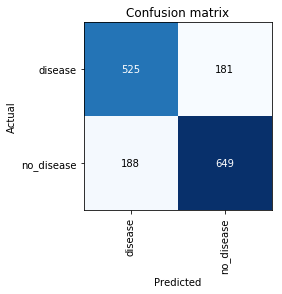

In [9]:
learn.save(f"{exp_label}_pneumo_{half_resolution}_before_unfreeze")
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [10]:
learn.load(f"{exp_label}_pneumo_{half_resolution}_before_unfreeze");

In [11]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


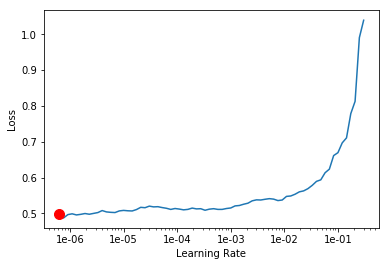

In [12]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,f_beta,f_beta,time
0,0.504859,0.477012,0.766688,0.797753,0.763441,0.850673,0.780220,0.770065,01:01
1,0.488014,0.455698,0.782890,0.820153,0.768220,0.866511,0.793337,0.778074,01:02
2,0.455958,0.420518,0.800389,0.824540,0.802867,0.887354,0.813559,0.807110,01:02
3,0.421900,0.395864,0.819183,0.872000,0.781362,0.899987,0.824197,0.797950,00:50
4,0.381543,0.381812,0.828905,0.854141,0.825567,0.907280,0.839611,0.831128,00:53
5,0.355577,0.362342,0.839922,0.887139,0.807646,0.917815,0.845528,0.822384,01:01
6,0.325145,0.352976,0.841866,0.885566,0.813620,0.920768,0.848070,0.827059,01:02
7,0.306855,0.337251,0.850940,0.889602,0.827957,0.927310,0.857673,0.839593,01:02
8,0.292765,0.334672,0.849644,0.874845,0.843489,0.927994,0.858881,0.849579,01:03
9,0.274968,0.336620,0.856773,0.918478,0.807646,0.930539,0.859504,0.827620,01:01


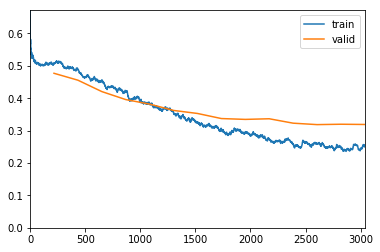

In [13]:
#learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-5))
lr = 1e-3
learn.fit_one_cycle(14, slice(1e-6,lr/5))
#learn.fit_one_cycle(1, lr, wd=1e-7)

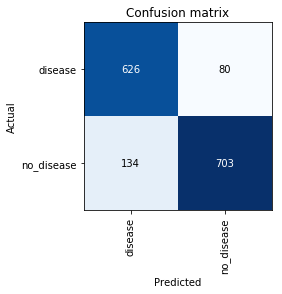

In [14]:
learn.save(f"{exp_label}_pneumo_{half_resolution}_after_unfreeze")
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [15]:
learn.load(f"{exp_label}_pneumo_{half_resolution}_after_unfreeze");

In [16]:
# Starting with image size 768
data = (src.transform(tfms, size=full_resolution)
           .databunch(bs=8, path='.').normalize(imagenet_stats))

In [17]:
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.58E-07


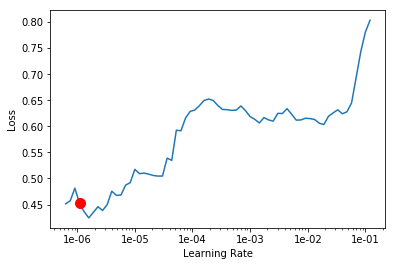

In [18]:
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,f_beta,f_beta,time
0,0.442877,0.501975,0.762800,0.823934,0.715651,0.839116,0.765985,0.734969,03:31
1,0.461507,0.456651,0.794556,0.786344,0.853047,0.870760,0.818338,0.838816,03:33
2,0.432579,0.447271,0.791316,0.819876,0.788530,0.870746,0.803898,0.794606,03:12
3,0.439442,0.410036,0.810758,0.826347,0.824373,0.894815,0.825359,0.824767,03:33
4,0.410618,0.408732,0.819183,0.813483,0.864994,0.898724,0.838448,0.854177,03:25
5,0.433650,0.402629,0.818535,0.845105,0.814815,0.898005,0.829684,0.820698,03:22


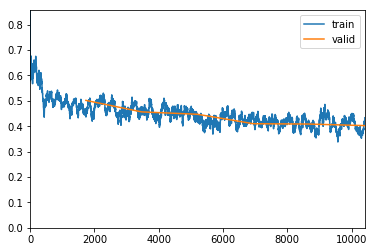

In [19]:
#learn.fit_one_cycle(10, 1e-6, wd=5e-6)
lr = 1e-3
learn.fit_one_cycle(6, slice(lr), wd=5e-6)
#learn.fit_one_cycle(1, slice(3e-3), wd=5e-6)

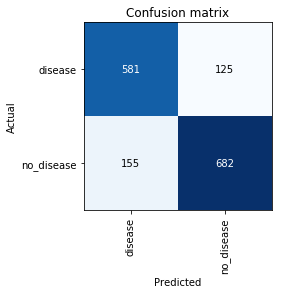

In [20]:
learn.save(f"{exp_label}_pneumo_{full_resolution}_before_unfreeze")
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [21]:
learn.unfreeze()
learn = learn.clip_grad();

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,f_beta,f_beta,time
0,0.381241,0.407701,0.823072,0.814031,0.873357,0.901407,0.842651,0.860810,05:31
1,0.413074,0.436883,0.805574,0.776519,0.900836,0.911229,0.834071,0.872887,05:29
2,0.376747,0.419365,0.821776,0.788501,0.917563,0.921949,0.848150,0.888478,05:17
3,0.381695,0.407772,0.839274,0.814973,0.910394,0.929940,0.860045,0.889563,05:44
4,0.311051,0.411455,0.843163,0.819549,0.911589,0.934746,0.863122,0.891563,05:20
5,0.381569,0.548520,0.823720,0.779980,0.940263,0.939770,0.852654,0.903144,05:20
6,0.382404,0.484596,0.847699,0.816176,0.928315,0.939751,0.868642,0.903488,05:40
7,0.379207,0.563130,0.854828,0.825027,0.929510,0.944486,0.874157,0.906549,05:18
8,0.380363,0.473304,0.891769,0.910539,0.887694,0.947811,0.898972,0.892171,05:34
9,0.313059,0.505234,0.898250,0.909639,0.902031,0.947172,0.905819,0.903542,05:28


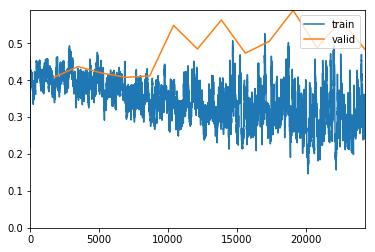

In [22]:
lr = 1e-3
learn.fit_one_cycle(14, slice(1e-6,lr/5))
#learn.fit_one_cycle(1, lr)
#learn.fit_one_cycle(5, slice(1e-6))

In [23]:
learn.save(f"{exp_label}_pneumo_{full_resolution}_after_unfreeze")


In [24]:
# BEST MODEL is loaded before running on test data
learn.load(f"{exp_label}_pneumo_{full_resolution}_after_unfreeze")

#learn.load(f"{exp_label}_pneumo_{half_resolution}_after_unfreeze");

Learner(data=ImageDataBunch;

Train: LabelList (13890 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
no_disease,no_disease,no_disease,no_disease,no_disease
Path: classifier_data_512;

Valid: LabelList (1543 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
disease,no_disease,no_disease,no_disease,disease
Path: classifier_data_512;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchN

In [25]:
sample_df = pd.read_csv('../sample_submission.csv')
sample_df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6067.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.6214.151787519...,-1
2,1.2.276.0.7230010.3.1.4.8323329.6177.151787519...,-1
3,1.2.276.0.7230010.3.1.4.8323329.6655.151787519...,-1
4,1.2.276.0.7230010.3.1.4.8323329.6359.151787519...,-1


In [26]:
#src = (ImageList.from_df(sample_df,f'../data{full_resolution}/',folder='test',suffix='.png'))
#src.databunch()
#src.
test_data = (ImageList.from_folder(f"../data_{full_resolution}/test/").split_none())
#test_data.
# Starting with image size 256
'''
src = (ImageList.from_folder(f"../data_{full_resolution}/test/")
           .label_from_folder

src = (ImageList.from_folder(f"classifier_data_{full_resolution}/")
                .split_by_rand_pct(0.1)
                .label_from_folder())
# Starting with image size 256
tfms = get_transforms(do_flip=True, max_rotate=15, flip_vert=False, max_lighting=0.1,
                      max_warp=0.,
                      xtra_tfms=[rand_crop(), rand_zoom(0.75, 1.25),
                                 symmetric_warp(magnitude=(-0.2, 0.2))])
data = (src.transform(tfms, size=half_resolution)
           .databunch(bs=64, path='.').normalize(imagenet_stats))
'''

#tfms = []

#test_data = src.normalize(imagenet_stats)

/home/msampat/miniconda3/envs/py/lib/python3.6/site-packages/fastai/data_block.py:451: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")


'\nsrc = (ImageList.from_folder(f"../data_{full_resolution}/test/")\n           .label_from_folder\n\nsrc = (ImageList.from_folder(f"classifier_data_{full_resolution}/")\n                .split_by_rand_pct(0.1)\n                .label_from_folder())\n# Starting with image size 256\ntfms = get_transforms(do_flip=True, max_rotate=15, flip_vert=False, max_lighting=0.1,\n                      max_warp=0.,\n                      xtra_tfms=[rand_crop(), rand_zoom(0.75, 1.25),\n                                 symmetric_warp(magnitude=(-0.2, 0.2))])\ndata = (src.transform(tfms, size=half_resolution)\n           .databunch(bs=64, path=\'.\').normalize(imagenet_stats))\n'

In [27]:
learn.data.add_test(ImageList.from_df(sample_df,f'../data{full_resolution}/',folder='test',suffix='.png'))
#test_data = (ImageList.from_folder(f"../data_{full_resolution}/test/").split_none()).normalize(imagenet_stats)
#test_data = (ImageList.from_folder(f"../data_{full_resolution}/test/").split_none()).normalize(imagenet_stats)
#t1 = (ImageList.from_folder(f"../data_{full_resolution}/test/").split_none())
#t2 = t1.datab



In [28]:
tta_params = {'beta':0.12, 'scale':1.0}
data.normalize
preds,_ = learn.TTA(ds_type=DatasetType.Test,**tta_params)
#preds,_ = learn.get_preds(ds_type=DatasetType.Test).
cls_pred = F.softmax(preds,1).argmax(1).cpu().numpy()
cls_pred = F.softmax(preds,1).argmax(1).cpu().numpy()

In [29]:

np.sum(cls_pred)

1070

In [30]:
np.sum(preds.argmax(1).numpy())

1070

In [31]:
paths = list(map(str,list(learn.data.test_ds.x.items)))
all_test_paths = [p.split('/')[-1][:-4] for p in paths]

df_preds = pd.DataFrame()
df_preds['test_paths'] = all_test_paths
df_preds['class_pred'] = cls_pred

df_preds.set_index('test_paths',inplace=True)

In [32]:
df_preds.head()

,class_pred
test_paths,
1.2.276.0.7230010.3.1.4.8323329.6067.1517875195.915618,1
1.2.276.0.7230010.3.1.4.8323329.6214.1517875197.83920,1
1.2.276.0.7230010.3.1.4.8323329.6177.1517875196.880733,0
1.2.276.0.7230010.3.1.4.8323329.6655.1517875199.413686,1
1.2.276.0.7230010.3.1.4.8323329.6359.1517875197.803699,1


In [33]:
no_dis_idx = df_preds[df_preds.class_pred==1].index
print(len(no_dis_idx))

1070


In [34]:
#sub = pd.read_csv('new_aug.csv',index_col=['ImageId'])
sub = pd.read_csv('hr_same_loss.csv',index_col=['ImageId'])
sub.head(25)
sub.fillna(value=' -1',inplace=True)
sub.head()


,EncodedPixels
ImageId,
1.2.276.0.7230010.3.1.4.8323329.6067.1517875195.915618,-1
1.2.276.0.7230010.3.1.4.8323329.6214.1517875197.83920,-1
1.2.276.0.7230010.3.1.4.8323329.6177.1517875196.880733,561232 5 1014 15 1008 17 1004 25 995 32 989 36...
1.2.276.0.7230010.3.1.4.8323329.6655.1517875199.413686,-1
1.2.276.0.7230010.3.1.4.8323329.6359.1517875197.803699,-1


In [35]:
sub.loc[no_dis_idx] = ' -1'


In [36]:
#sub.to_csv(f'{exp_label}_{model_name}_{half_resolution}_{full_resolution}_classifier_correction_final_model_with_tta.csv')
sub.to_csv(f'hr_same_loss_{exp_label}_{model_name}_{half_resolution}_{full_resolution}_classifier_correction_final_model_with_tta_duplicate_disease.csv')

In [37]:
interp = ClassificationInterpretation.from_learner(learn)

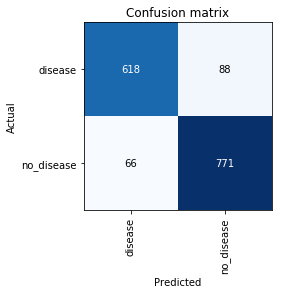

In [38]:
interp.plot_confusion_matrix()

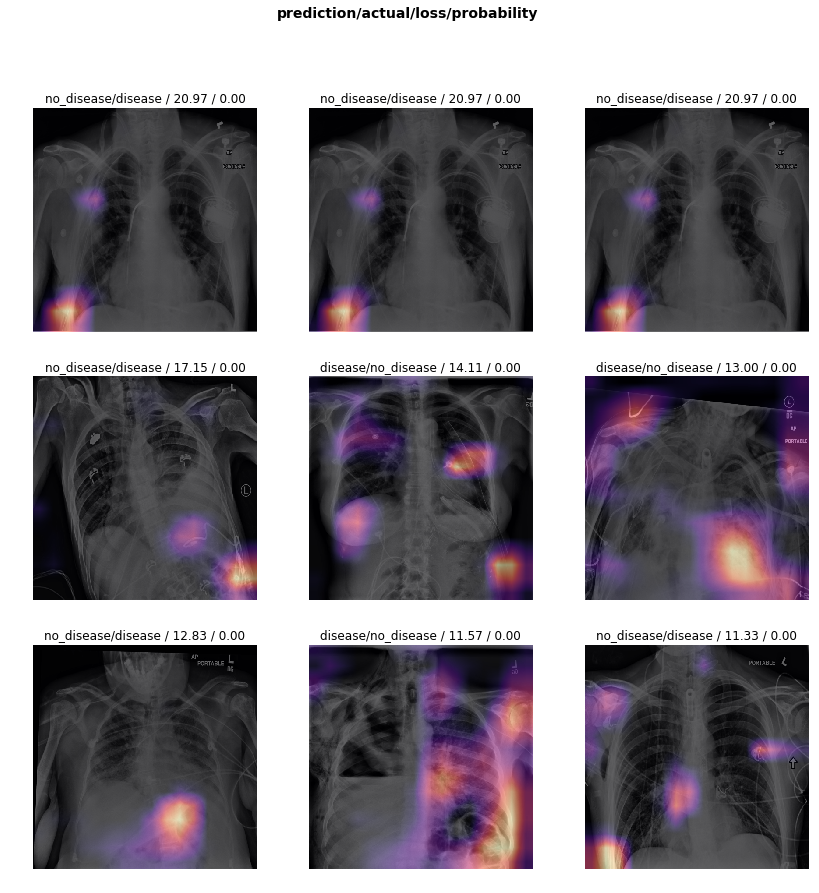

In [39]:
interp.plot_top_losses(9, figsize=(14,14))